# Project Introduction

Through looking at a simple data set containing the scores of each NFL game, the betting line involved, and a few other explanatory details about the game being played, I decided to set out to answer questions I had about the accuracy of NFL betting lines. 

I tried predicting many different things due to the various amounts of features I needed to create for a pretty basic dataset, so ultimately I tried predicting a few things based on what model I wanted to use. Among the variables I tried predicting were the actual score difference, the margin the favorite to win beat the spread by, and a binary result of whether the home team can be expected to win or not.

## Importing and Cleaning the Data Section

In [320]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import regex as re
plt.style.use('ggplot')

In [321]:
games = pd.read_csv('/Users/scottgill/Desktop/CurrentCourseAssignments/Stat426/Project/Data/spreadspoke_scores.csv')
teams = pd.read_csv('/Users/scottgill/Desktop/CurrentCourseAssignments/Stat426/Project/Data/nfl_teams.csv')
stadiums = pd.read_csv('/Users/scottgill/Desktop/CurrentCourseAssignments/Stat426/Project/Data/nfl_stadiums.csv', encoding = "ISO-8859-1")


In [322]:
#Removing games from 2020 that haven't happened yet
games.isnull().sum()
games = games[games['score_home'].notna()]
print(games.isnull().sum())
print(games.shape)
print(games.dtypes)

schedule_date              0
schedule_season            0
schedule_week              0
schedule_playoff           0
team_home                  0
score_home                 0
score_away                 0
team_away                  0
team_favorite_id        2479
spread_favorite         2479
over_under_line         2489
stadium                    0
stadium_neutral            0
weather_temperature      825
weather_wind_mph         825
weather_humidity        4409
weather_detail         10122
dtype: int64
(12797, 17)
schedule_date           object
schedule_season          int64
schedule_week           object
schedule_playoff          bool
team_home               object
score_home             float64
score_away             float64
team_away               object
team_favorite_id        object
spread_favorite        float64
over_under_line         object
stadium                 object
stadium_neutral           bool
weather_temperature    float64
weather_wind_mph       float64
weather_humidity 

In [323]:
games2000 = games[(games['schedule_season'] > 1999) & (games['schedule_season'] < 2020) ] #grabbing games only later than 2000, but before 2020 started (with no fans)

In [324]:
games2000.schedule_playoff.value_counts() #checking to see how many playoff games we have in the dataset

False    5104
True      220
Name: schedule_playoff, dtype: int64

In [325]:
#Dropping unnecessary columns from stadiums df
stadiums = stadiums.drop(['stadium_address', 'stadium_weather_station_code', 'STATION', 'NAME', 'LATITUDE', 'LONGITUDE'], axis=1)

In [326]:
games2000.rename(columns={'stadium': 'stadium_name'}, inplace=True) #changing column name so we can merge easier

#Joining both dataframes together
df = pd.merge(games2000, stadiums, on = 'stadium_name', how = 'left')

/Applications/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [327]:
#Dropping more unnecessary columns
df = df.drop(['stadium_close', 'weather_humidity'], axis=1) #too many NA's in weather humidity

In [328]:
#Changing datatype for schedule date column
df['schedule_date'] = pd.to_datetime(df['schedule_date'])

In [329]:
print(df.dtypes)
df

schedule_date           datetime64[ns]
schedule_season                  int64
schedule_week                   object
schedule_playoff                  bool
team_home                       object
score_home                     float64
score_away                     float64
team_away                       object
team_favorite_id                object
spread_favorite                float64
over_under_line                 object
stadium_name                    object
stadium_neutral                   bool
weather_temperature            float64
weather_wind_mph               float64
weather_detail                  object
stadium_location                object
stadium_open                   float64
stadium_type                    object
stadium_weather_type            object
stadium_capacity                object
stadium_surface                 object
ELEVATION                      float64
dtype: object


,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,...,weather_temperature,weather_wind_mph,weather_detail,stadium_location,stadium_open,stadium_type,stadium_weather_type,stadium_capacity,stadium_surface,ELEVATION
0,2000-09-03,2000,1,False,Atlanta Falcons,36.0,28.0,San Francisco 49ers,ATL,-6.5,...,72.0,0.0,DOME,"Atlanta, GA",1992.0,indoor,dome,"71,250",FieldTurf,NaN
1,2000-09-03,2000,1,False,Buffalo Bills,16.0,13.0,Tennessee Titans,BUF,-1.0,...,70.0,7.0,NaN,"Orchard Park, NY",1973.0,outdoor,cold,"73,967",FieldTurf,178.0
2,2000-09-03,2000,1,False,Cleveland Browns,7.0,27.0,Jacksonville Jaguars,JAX,-10.5,...,75.0,8.0,NaN,"Cleveland, OH",1999.0,outdoor,cold,"68,000",Grass,238.0
3,2000-09-03,2000,1,False,Dallas Cowboys,14.0,41.0,Philadelphia Eagles,DAL,-6.0,...,95.0,7.0,NaN,"Irving, TX",1971.0,outdoor,moderate,NaN,NaN,163.4
4,2000-09-03,2000,1,False,Green Bay Packers,16.0,20.0,New York Jets,GB,-2.5,...,69.0,13.0,NaN,"Green Bay, WI",1957.0,outdoor,cold,"80,735",Grass,209.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5319,2020-01-12,2019,Division,True,Green Bay Packers,28.0,23.0,Seattle Seahawks,GB,-4.5,...,NaN,NaN,NaN,"Green Bay, WI",1957.0,outdoor,cold,"80,735",Grass,209.4
5320,2020-01-12,2019,Division,True,Kansas City Chiefs,51.0,31.0,Houston Texans,KC,-10.0,...,NaN,NaN,NaN,"Kansas City, MO",1972.0,outdoor,cold,"76,416",Grass,264.9
5321,2020-01-19,2019,Conference,True,Kansas City Chiefs,35.0,24.0,Tennessee Titans,KC,-7.0,...,NaN,NaN,NaN,"Kansas City, MO",1972.0,outdoor,cold,"76,416",Grass,264.9
5322,2020-01-19,2019,Conference,True,San Francisco 49ers,37.0,20.0,Green Bay Packers,SF,-8.0,...,NaN,NaN,NaN,"Santa Clara, CA",2014.0,outdoor,moderate,"68,500",Grass,2.4


## Cleaning the Data/Dealing with the many existing nulls

In [330]:
df.isna().sum()

schedule_date              0
schedule_season            0
schedule_week              0
schedule_playoff           0
team_home                  0
score_home                 0
score_away                 0
team_away                  0
team_favorite_id           0
spread_favorite            0
over_under_line            0
stadium_name               0
stadium_neutral            0
weather_temperature      321
weather_wind_mph         321
weather_detail          3859
stadium_location         178
stadium_open             189
stadium_type             180
stadium_weather_type     180
stadium_capacity        1145
stadium_surface         1145
ELEVATION               1069
dtype: int64

In [331]:
df["schedule_playoff"] = df["schedule_playoff"].astype(int)

In [332]:
#Changing weeks that are strings to integers for later model predictions
df.loc[(df.schedule_week == '18'), 'schedule_week'] = '17'
df.loc[(df.schedule_week == 'Wildcard') | (df.schedule_week == 'WildCard'), 'schedule_week'] = '18'
df.loc[(df.schedule_week == 'Division'), 'schedule_week'] = '19'
df.loc[(df.schedule_week == 'Conference'), 'schedule_week'] = '20'
df.loc[(df.schedule_week == 'Superbowl') | (df.schedule_week == 'SuperBowl'), 'schedule_week'] = '21'
df['schedule_week'] = df.schedule_week.astype(int)
df

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,...,weather_temperature,weather_wind_mph,weather_detail,stadium_location,stadium_open,stadium_type,stadium_weather_type,stadium_capacity,stadium_surface,ELEVATION
0,2000-09-03,2000,1,0,Atlanta Falcons,36.0,28.0,San Francisco 49ers,ATL,-6.5,...,72.0,0.0,DOME,"Atlanta, GA",1992.0,indoor,dome,"71,250",FieldTurf,NaN
1,2000-09-03,2000,1,0,Buffalo Bills,16.0,13.0,Tennessee Titans,BUF,-1.0,...,70.0,7.0,NaN,"Orchard Park, NY",1973.0,outdoor,cold,"73,967",FieldTurf,178.0
2,2000-09-03,2000,1,0,Cleveland Browns,7.0,27.0,Jacksonville Jaguars,JAX,-10.5,...,75.0,8.0,NaN,"Cleveland, OH",1999.0,outdoor,cold,"68,000",Grass,238.0
3,2000-09-03,2000,1,0,Dallas Cowboys,14.0,41.0,Philadelphia Eagles,DAL,-6.0,...,95.0,7.0,NaN,"Irving, TX",1971.0,outdoor,moderate,NaN,NaN,163.4
4,2000-09-03,2000,1,0,Green Bay Packers,16.0,20.0,New York Jets,GB,-2.5,...,69.0,13.0,NaN,"Green Bay, WI",1957.0,outdoor,cold,"80,735",Grass,209.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5319,2020-01-12,2019,19,1,Green Bay Packers,28.0,23.0,Seattle Seahawks,GB,-4.5,...,NaN,NaN,NaN,"Green Bay, WI",1957.0,outdoor,cold,"80,735",Grass,209.4
5320,2020-01-12,2019,19,1,Kansas City Chiefs,51.0,31.0,Houston Texans,KC,-10.0,...,NaN,NaN,NaN,"Kansas City, MO",1972.0,outdoor,cold,"76,416",Grass,264.9
5321,2020-01-19,2019,20,1,Kansas City Chiefs,35.0,24.0,Tennessee Titans,KC,-7.0,...,NaN,NaN,NaN,"Kansas City, MO",1972.0,outdoor,cold,"76,416",Grass,264.9
5322,2020-01-19,2019,20,1,San Francisco 49ers,37.0,20.0,Green Bay Packers,SF,-8.0,...,NaN,NaN,NaN,"Santa Clara, CA",2014.0,outdoor,moderate,"68,500",Grass,2.4


In [333]:
#Cleaning Stadium location

df[df['stadium_location'].isnull()].team_home.value_counts() #Seeing which Teams have NA's for stadium location
df.loc[df.team_home == "Washington Redskins", "stadium_location"] = 'Landover, MD'
df.loc[df.team_home == "Oakland Raiders", "stadium_location"] = 'Oakland, CA'
df.loc[df.team_home == "Tampa Bay Buccaneers", "stadium_location"] = 'Tampa, FL'

#Jaguars are messy because they've played many games in London as the "Home" team
df['stadium_location'] = df['stadium_location'].fillna('Jacksonville, FL')

df.stadium_location.value_counts()



East Rutherford, NJ    328
Foxborough, MA         184
Philadelphia, PA       174
Pittsburgh, PA         173
Green Bay, WI          172
Indianapolis, IN       172
Seattle, WA            171
Denver, CO             169
Kansas City, MO        167
Baltimore, MD          167
Charlotte, NC          166
Atlanta, GA            166
Oakland, CA            166
Glendale, AZ           165
Tampa, FL              165
Minneapolis, MN        164
Nashville, TN          163
Cincinnati, OH         163
Landover, MD           162
Miami Gardens, FL      162
New Orleans, LA        162
Cleveland, OH          159
Chicago, IL            157
Jacksonville, FL       155
Orchard Park, NY       153
Houston, TX            152
Detroit, MI            147
San Diego, CA          140
St. Louis, MO          130
San Francisco, CA      115
Arlington, TX           93
Irving, TX              73
Los Angeles, CA         53
Santa Clara, CA         51
London, UK              22
Pontiac, MI             16
Champaign, IL           10
T

In [334]:
#Cleaning the stadium open column
df[df['stadium_open'].isnull()].team_home.value_counts() #Redskins 1997, Jags 1995, Bills 1973, Saints 1975, Raiders 1966

df.loc[df.team_home == "Washington Redskins", "stadium_open"] = 1997
df.loc[df.team_home == "Jacksonville Jaguars", "stadium_open"] = 1995
df.loc[df.team_home == "Buffalo Bills", "stadium_open"] = 1973
df.loc[df.team_home == "New Orleans Saints", "stadium_open"] = 1975
df.loc[df.team_home == "Oakland Raiders", "stadium_open"] = 1966
df['stadium_open'] = df['stadium_open'].fillna(df['stadium_open'].mean()) #filling the last 3 with just the column mean


In [335]:
#stadium_capacity cleaning - uncomment the first line once and run
df['stadium_capacity'] = df['stadium_capacity'].str.replace(',', '').astype(float)
df['stadium_capacity'] = df['stadium_capacity'].fillna(df.groupby('team_home')['stadium_capacity'].transform('mean'))
df['stadium_capacity'] = df['stadium_capacity'].fillna(65488) #this accounts for the Washington Football Team, which had no attendance record in this dataset. A reliable source stated that this was their average game attendance in the 2000s

In [336]:
#Stadium_type cleaning

df[df['stadium_type'].isnull()].team_home.value_counts()
df[df['stadium_type'].isnull()]
df.stadium_type.value_counts()

#Cleaning the Redskins
df.loc[df.team_home == "Washington Redskins", "stadium_type"] = 'outdoor'

#Rest of the NA's were played outdoor, including the two Super Bowls
df['stadium_type'] = df['stadium_type'].fillna('outdoor')


In [337]:
#Cleaning the Temperature column
df['weather_temperature'] = df['weather_temperature'].fillna(df.groupby('team_home')['weather_temperature'].transform('mean'))

In [338]:
#Cleaning the Wind column
df['weather_wind_mph'] = df['weather_wind_mph'].fillna(df.groupby('team_home')['weather_wind_mph'].transform('mean'))

In [339]:
#Cleaning Elevation column
meters = 0.3048

print(df[df['ELEVATION'].isnull()].team_home.value_counts()) #Looks like all Saints, Falcons, Redskins, Lions, Colts, and Rams games are missing elevation
df.loc[df.stadium_location == "New Orleans, LA", "ELEVATION"] = 3*meters #Only could find elevation in feet, dataset is in meters, data according to ArcGIS
df.loc[df.stadium_location == "Atlanta, GA", "ELEVATION"] = 997*meters
df.loc[df.stadium_location == "Landover, MD", "ELEVATION"] = 197*meters
df.loc[df.team_home == "Detroit Lions", "ELEVATION"] = 604*meters
df.loc[df.stadium_location == "Minneapolis, MN", "ELEVATION"] = 853*meters
df.loc[df.stadium_location == "St. Louis, MO", "ELEVATION"] = 466*meters
df.loc[df.stadium_location == "London, UK", "ELEVATION"] = 36*meters
df.loc[df.stadium_location == "Indianapolis, IN", "ELEVATION"] = 709*meters
df['ELEVATION'] = df['ELEVATION'].fillna(df['ELEVATION'].median()) #filling the last few missing with the column median


New Orleans Saints      168
Atlanta Falcons         166
Washington Redskins     162
Detroit Lions           160
Minnesota Vikings       147
St. Louis Rams          132
Indianapolis Colts       71
Jacksonville Jaguars     20
Chicago Bears            10
Buffalo Bills             7
Oakland Raiders           5
Los Angeles Rams          4
Miami Dolphins            3
Tampa Bay Buccaneers      3
San Francisco 49ers       2
Los Angeles Chargers      2
Pittsburgh Steelers       1
New England Patriots      1
Cleveland Browns          1
Cincinnati Bengals        1
Philadelphia Eagles       1
Arizona Cardinals         1
Kansas City Chiefs        1
Name: team_home, dtype: int64


In [340]:
#stadium_weather_type cleaning
#Using ffill to take surrounding observations and fill NA's - this should work since it will take values based on time of when it will be warm/cold around it
df['stadium_weather_type'] = df['stadium_weather_type'].fillna(method = 'ffill') #hope is that data proportion will be preserved
df.stadium_weather_type.value_counts() #proportions appear to be preserved

cold        2038
dome        1387
moderate    1186
warm         713
Name: stadium_weather_type, dtype: int64

In [341]:
#Stadium surface cleaning - not done yet

df[df['stadium_surface'].isnull()].team_home.value_counts() #Too many teams to try and correct data for all of them
print(df.stadium_surface.value_counts())

df.stadium_surface = df.stadium_surface.fillna(method = 'ffill') #Using ffill again to preserve proportion
df.stadium_surface.value_counts() #proportion appears preserved again

Grass        2505
FieldTurf    1674
Name: stadium_surface, dtype: int64


Grass        3348
FieldTurf    1976
Name: stadium_surface, dtype: int64

In [342]:
#Cleaning Weather Detail column - Assuming observations with no data available had no conditions since it wasn't accounted for
df.weather_detail = df.weather_detail.fillna('Normal')

print(df.weather_detail.value_counts())

#Combining data to create less levels
df.loc[df.weather_detail == "Rain | Fog", "weather_detail"] = 'Rain'
df.loc[df.weather_detail == "DOME (Open Roof)", "weather_detail"] = 'Normal'
df.loc[df.weather_detail == "Snow | Fog", "weather_detail"] = 'Snow'
df.loc[df.weather_detail == "Snow | Freezing Rain", "weather_detail"] = 'Snow'

#Dome should also be normal weather since there's no condition
df.loc[df.weather_detail == "DOME", "weather_detail"] = 'Normal'

df.weather_detail.value_counts()

Normal                  3859
DOME                    1233
Rain                     106
DOME (Open Roof)          56
Fog                       28
Rain | Fog                22
Snow                      14
Snow | Fog                 5
Snow | Freezing Rain       1
Name: weather_detail, dtype: int64


Normal    5148
Rain       128
Fog         28
Snow        20
Name: weather_detail, dtype: int64

In [343]:
df.isna().sum()

schedule_date           0
schedule_season         0
schedule_week           0
schedule_playoff        0
team_home               0
score_home              0
score_away              0
team_away               0
team_favorite_id        0
spread_favorite         0
over_under_line         0
stadium_name            0
stadium_neutral         0
weather_temperature     0
weather_wind_mph        0
weather_detail          0
stadium_location        0
stadium_open            0
stadium_type            0
stadium_weather_type    0
stadium_capacity        0
stadium_surface         0
ELEVATION               0
dtype: int64

## Adding New/Necessary Columns

In [344]:
df['score_difference'] = abs(df['score_home'] - df['score_away']) #calculating a margin for each game

In [345]:
#Converting the Over/Under score to a numeric score
df["over_under_line"] = pd.to_numeric(df["over_under_line"])

In [346]:
#Creating a column to see how close the over/prediction is to actual
df['over_under_accuracy'] = (df['score_home'] + df['score_away']) - df['over_under_line']

In [347]:
#Creating columns for nicknames of home/away teams to make divisional games make more sense
df["home_nickname"] = df["team_home"].str.split().str[-1]

df["away_nickname"] = df["team_away"].str.split().str[-1]

In [348]:
#Create dictionaries for division of teams
Divisions = {
    'NFCW': ['Cardinals', '49ers', 'Rams', 'Seahawks'],
    'NFCN': ['Bears', 'Packers', 'Lions', 'Vikings'],
    'NFCE': ['Cowboys', 'Eagles', 'Redskins', 'Giants'],
    'NFCS': ['Panthers', 'Saints', 'Buccaneers', 'Falcons'],
    'AFCW': ['Chiefs', 'Chargers', 'Broncos', 'Raiders'],
    'AFCN': ['Browns', 'Bengals', 'Steelers', 'Ravens'],
    'AFCE': ['Jets', 'Patriots', 'Dolphins', 'Bills'],
    'AFCS': ['Titans', 'Texans', 'Colts', 'Jaguars']
}
divisions = pd.DataFrame(Divisions)
divisions

div_dict = {
    'Cardinals': 'NFCW', '49ers': 'NFCW', 'Rams': 'NFCW', 'Seahawks': 'NFCW', 
    'Bears': 'NFCN', 'Packers': 'NFCN', 'Lions': 'NFCN', 'Vikings': 'NFCN', 
    'Cowboys': 'NFCE', 'Eagles': 'NFCE', 'Redskins': 'NFCE', 'Giants': 'NFCE', 
    'Panthers': 'NFCS','Saints': 'NFCS',  'Buccaneers': 'NFCS', 'Falcons': 'NFCS', 
    'Chiefs': 'AFCW', 'Chargers': 'AFCW', 'Broncos': 'AFCW', 'Raiders': 'AFCW', 
    'Browns': 'AFCN', 'Bengals': 'AFCN', 'Steelers': 'AFCN', 'Ravens': 'AFCN', 
    'Jets': 'AFCE', 'Patriots': 'AFCE', 'Dolphins': 'AFCE', 'Bills': 'AFCE', 
    'Titans': 'AFCS','Texans': 'AFCS',  'Colts': 'AFCS', 'Jaguars': 'AFCS', 
}
div_dict

{'Cardinals': 'NFCW',
 '49ers': 'NFCW',
 'Rams': 'NFCW',
 'Seahawks': 'NFCW',
 'Bears': 'NFCN',
 'Packers': 'NFCN',
 'Lions': 'NFCN',
 'Vikings': 'NFCN',
 'Cowboys': 'NFCE',
 'Eagles': 'NFCE',
 'Redskins': 'NFCE',
 'Giants': 'NFCE',
 'Panthers': 'NFCS',
 'Saints': 'NFCS',
 'Buccaneers': 'NFCS',
 'Falcons': 'NFCS',
 'Chiefs': 'AFCW',
 'Chargers': 'AFCW',
 'Broncos': 'AFCW',
 'Raiders': 'AFCW',
 'Browns': 'AFCN',
 'Bengals': 'AFCN',
 'Steelers': 'AFCN',
 'Ravens': 'AFCN',
 'Jets': 'AFCE',
 'Patriots': 'AFCE',
 'Dolphins': 'AFCE',
 'Bills': 'AFCE',
 'Titans': 'AFCS',
 'Texans': 'AFCS',
 'Colts': 'AFCS',
 'Jaguars': 'AFCS'}

In [349]:
df["home_division"] = df["home_nickname"].map(div_dict)
df["away_division"] = df["away_nickname"].map(div_dict)
df

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,...,stadium_weather_type,stadium_capacity,stadium_surface,ELEVATION,score_difference,over_under_accuracy,home_nickname,away_nickname,home_division,away_division
0,2000-09-03,2000,1,0,Atlanta Falcons,36.0,28.0,San Francisco 49ers,ATL,-6.5,...,dome,71250.0,FieldTurf,303.8856,8.0,17.5,Falcons,49ers,NFCS,NFCW
1,2000-09-03,2000,1,0,Buffalo Bills,16.0,13.0,Tennessee Titans,BUF,-1.0,...,cold,73967.0,FieldTurf,178.0000,3.0,-11.0,Bills,Titans,AFCE,AFCS
2,2000-09-03,2000,1,0,Cleveland Browns,7.0,27.0,Jacksonville Jaguars,JAX,-10.5,...,cold,68000.0,Grass,238.0000,20.0,-4.5,Browns,Jaguars,AFCN,AFCS
3,2000-09-03,2000,1,0,Dallas Cowboys,14.0,41.0,Philadelphia Eagles,DAL,-6.0,...,moderate,80000.0,Grass,163.4000,27.0,15.5,Cowboys,Eagles,NFCE,NFCE
4,2000-09-03,2000,1,0,Green Bay Packers,16.0,20.0,New York Jets,GB,-2.5,...,cold,80735.0,Grass,209.4000,4.0,-8.0,Packers,Jets,NFCN,AFCE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5319,2020-01-12,2019,19,1,Green Bay Packers,28.0,23.0,Seattle Seahawks,GB,-4.5,...,cold,80735.0,Grass,209.4000,5.0,5.5,Packers,Seahawks,NFCN,NFCW
5320,2020-01-12,2019,19,1,Kansas City Chiefs,51.0,31.0,Houston Texans,KC,-10.0,...,cold,76416.0,Grass,264.9000,20.0,31.5,Chiefs,Texans,AFCW,AFCS
5321,2020-01-19,2019,20,1,Kansas City Chiefs,35.0,24.0,Tennessee Titans,KC,-7.0,...,cold,76416.0,Grass,264.9000,11.0,8.0,Chiefs,Titans,AFCW,AFCS
5322,2020-01-19,2019,20,1,San Francisco 49ers,37.0,20.0,Green Bay Packers,SF,-8.0,...,moderate,68500.0,Grass,2.4000,17.0,10.5,49ers,Packers,NFCW,NFCN


In [350]:
#Creating a function that identifies whether the participating teams are in the same division
def divisional(row):
    if row['home_division'] == row['away_division']:
        val = 'True'
    else:
        val = 'False'
    return val

df['division_game'] = df.apply(divisional, axis=1)


df.loc[df.division_game == 'False', 'division_game'] = 0
df.loc[df.division_game == 'True', 'division_game'] = 1

In [351]:
# Creating a resulting Winner column identifying which team wins the game
df['Winner'] = df.loc[(df.score_home > df.score_away), 'team_home']
df['Winner'] = df['Winner'].fillna(df.team_away)


In [352]:
#Creating a binary column to determine whether home team won or not
df['result'] = (df.score_home > df.score_away).astype(int)

In [353]:
#Creating another list for team ID to make working with team_favorite_id easier
team_abb = [('ATL','Falcons'),
            ('BUF', 'Bills'),
            ('JAX','Jaguars'),
            ('DAL', 'Cowboys'),
            ('GB', 'Packers'),
            ('IND','Colts'),
            ('MIA', 'Dolphins'),
            ('MIN','Vikings'),
            ('TB', 'Buccaneers'),
            ('NYG','Giants'),
            ('OAK', 'Raiders'),
            ('BAL','Ravens'),
            ('WAS', 'Redskins'),
            ('LAR', 'Rams'),
            ('ARI', 'Cardinals'),
            ('CIN', 'Bengals'),
            ('DEN', 'Broncos'),
            ('PHI', 'Eagles'),
            ('LAC','Chargers'),
            ('CAR','Panthers'),
            ('TEN','Titans'),
            ('NYJ', 'Jets'),
            ('CHI', 'Bears'),
            ('PIT', 'Steelers'),
            ('KC', 'Chiefs'),
            ('NE','Patriots'),
            ('SEA','Seahawks'),
            ('NO', 'Saints'),
            ('DET', 'Lions'),
            ('SF', '49ers'),
            ('CLE', 'Browns'),
            ('HOU', 'Texans')]

In [354]:
# Changing team abbreviations to be the actual team nickname
for team in team_abb:
    df.team_favorite_id.replace(team[0], team[1],inplace=True)
    

In [355]:
# creating binary home favorite and away favorite columns
df['home_favorite'] = np.where(df['home_nickname']==df['team_favorite_id'], 1, 0)
df['away_favorite'] = np.where(df['away_nickname']==df['team_favorite_id'], 1, 0)
df.home_favorite.fillna(0, inplace=True)
df.away_favorite.fillna(0, inplace=True)


In [356]:
# Determines whether or not favorite was the home team, and how much the favorite won by
def Fav_MoV (row):
    # Determines whether the favorite was the home team
    if re.search(row['team_favorite_id'], row['team_home'], re.IGNORECASE):
        return row['score_home']-row['score_away']
    else:
        return row['score_away']-row['score_home']
    

df['fav_MoV'] = df.apply(lambda row: Fav_MoV(row), axis=1)


In [357]:
#Function to determine how much the favorite beat the spread by
def Fav_Spread_MoV (row):
    return row['spread_favorite'] + row['fav_MoV']  

df['fav_spread_MoV'] = df.apply(lambda row: Fav_Spread_MoV(row),axis=1)

In [358]:
df.columns

Index(['schedule_date', 'schedule_season', 'schedule_week', 'schedule_playoff',
       'team_home', 'score_home', 'score_away', 'team_away',
       'team_favorite_id', 'spread_favorite', 'over_under_line',
       'stadium_name', 'stadium_neutral', 'weather_temperature',
       'weather_wind_mph', 'weather_detail', 'stadium_location',
       'stadium_open', 'stadium_type', 'stadium_weather_type',
       'stadium_capacity', 'stadium_surface', 'ELEVATION', 'score_difference',
       'over_under_accuracy', 'home_nickname', 'away_nickname',
       'home_division', 'away_division', 'division_game', 'Winner', 'result',
       'home_favorite', 'away_favorite', 'fav_MoV', 'fav_spread_MoV'],
      dtype='object')

In [359]:
#Rearranging column names
df = df[['schedule_date', 'schedule_season', 'schedule_week', 'schedule_playoff', 'division_game', 
       'team_home', 'home_nickname', 'score_home', 'score_away', 'team_away', 'away_nickname',  'Winner',
       'stadium_name', 'stadium_neutral', 'weather_temperature',
       'weather_wind_mph', 'weather_detail', 'stadium_location', 'stadium_open', 'stadium_type',
       'stadium_weather_type', 'stadium_capacity', 'stadium_surface', 'ELEVATION',
        'team_favorite_id', 'spread_favorite', 'score_difference', 'over_under_line', 'over_under_accuracy',
         'fav_MoV', 'fav_spread_MoV', 'home_favorite', 'away_favorite', 'result',]]

## EDA Section - Figuring out which variable would be best to try to predict

In [360]:
df

,schedule_date,schedule_season,schedule_week,schedule_playoff,division_game,team_home,home_nickname,score_home,score_away,team_away,...,team_favorite_id,spread_favorite,score_difference,over_under_line,over_under_accuracy,fav_MoV,fav_spread_MoV,home_favorite,away_favorite,result
0,2000-09-03,2000,1,0,0,Atlanta Falcons,Falcons,36.0,28.0,San Francisco 49ers,...,Falcons,-6.5,8.0,46.5,17.5,8.0,1.5,1,0,1
1,2000-09-03,2000,1,0,0,Buffalo Bills,Bills,16.0,13.0,Tennessee Titans,...,Bills,-1.0,3.0,40.0,-11.0,3.0,2.0,1,0,1
2,2000-09-03,2000,1,0,0,Cleveland Browns,Browns,7.0,27.0,Jacksonville Jaguars,...,Jaguars,-10.5,20.0,38.5,-4.5,20.0,9.5,0,1,0
3,2000-09-03,2000,1,0,1,Dallas Cowboys,Cowboys,14.0,41.0,Philadelphia Eagles,...,Cowboys,-6.0,27.0,39.5,15.5,-27.0,-33.0,1,0,0
4,2000-09-03,2000,1,0,0,Green Bay Packers,Packers,16.0,20.0,New York Jets,...,Packers,-2.5,4.0,44.0,-8.0,-4.0,-6.5,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5319,2020-01-12,2019,19,1,0,Green Bay Packers,Packers,28.0,23.0,Seattle Seahawks,...,Packers,-4.5,5.0,45.5,5.5,5.0,0.5,1,0,1
5320,2020-01-12,2019,19,1,0,Kansas City Chiefs,Chiefs,51.0,31.0,Houston Texans,...,Chiefs,-10.0,20.0,50.5,31.5,20.0,10.0,1,0,1
5321,2020-01-19,2019,20,1,0,Kansas City Chiefs,Chiefs,35.0,24.0,Tennessee Titans,...,Chiefs,-7.0,11.0,51.0,8.0,11.0,4.0,1,0,1
5322,2020-01-19,2019,20,1,0,San Francisco 49ers,49ers,37.0,20.0,Green Bay Packers,...,49ers,-8.0,17.0,46.5,10.5,17.0,9.0,1,0,1


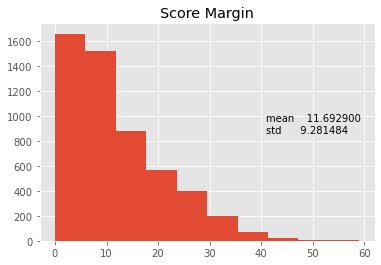

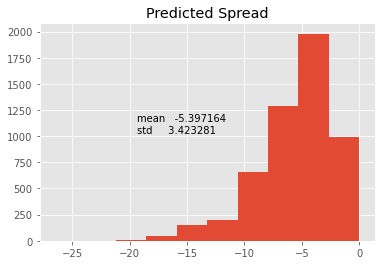

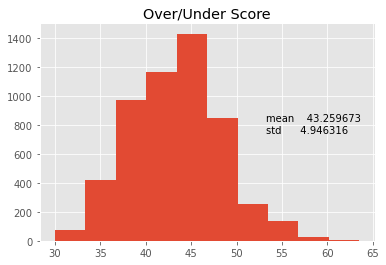

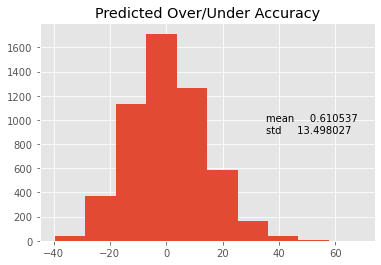

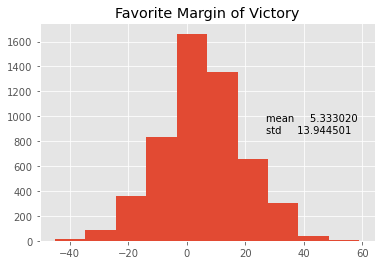

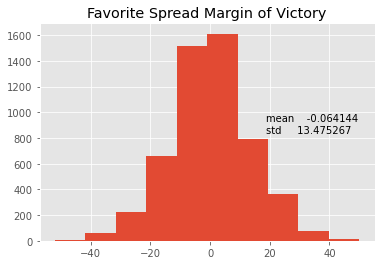

In [361]:
#Plotting distributions for a few different variables
plt.hist(df.score_difference)
plt.figtext(0.65,0.5, df.score_difference.describe().loc[['mean','std']].to_string())
plt.title('Score Margin')
plt.show()
plt.hist(df.spread_favorite)
plt.figtext(0.35,0.5, df.spread_favorite.describe().loc[['mean','std']].to_string())
plt.title('Predicted Spread')
plt.show()
plt.hist(df.over_under_line)
plt.figtext(0.65,0.5, df.over_under_line.describe().loc[['mean','std']].to_string())
plt.title('Over/Under Score')
plt.show()
plt.hist(df.over_under_accuracy)
plt.figtext(0.65,0.5, df.over_under_accuracy.describe().loc[['mean','std']].to_string())
plt.title('Predicted Over/Under Accuracy')
plt.show()
plt.hist(df.fav_MoV)
plt.figtext(0.65,0.5, df.fav_MoV.describe().loc[['mean','std']].to_string())
plt.title('Favorite Margin of Victory')
plt.show()
plt.hist(df.fav_spread_MoV)
plt.figtext(0.65,0.5, df.fav_spread_MoV.describe().loc[['mean','std']].to_string())
plt.title('Favorite Spread Margin of Victory')
plt.show()

In [362]:
df.describe().transpose() #Running summary statistics for games

#Biggest observation - on average, the favorite wins by 5. However the spread MoV average is right on the money at -.06

,count,mean,std,min,25%,50%,75%,max
schedule_season,5324.0,2009.527047,5.754236,2000.0000,2005.0,2010.0,2015.000000,2019.0
schedule_week,5324.0,9.511833,5.271909,1.0000,5.0,10.0,14.000000,21.0
schedule_playoff,5324.0,0.041322,0.199053,0.0000,0.0,0.0,0.000000,1.0
score_home,5324.0,23.159842,10.382276,0.0000,16.0,23.0,30.000000,62.0
score_away,5324.0,20.710368,10.088146,0.0000,13.0,20.0,27.000000,59.0
weather_temperature,5324.0,60.289000,15.354138,-6.0000,50.0,63.0,72.000000,97.0
weather_wind_mph,5324.0,6.380589,5.324449,0.0000,1.0,6.0,10.000000,40.0
stadium_open,5324.0,1989.093967,19.077342,1909.0000,1975.0,1997.0,2002.000000,2017.0
stadium_capacity,5324.0,69969.871740,7302.570992,27000.0000,65500.0,68756.0,76117.331288,93605.0
ELEVATION,5324.0,178.415612,283.340807,0.9144,8.8,145.4,216.103200,1611.2


EDA of Playoff Games

In [363]:
playoffs = df.loc[df['schedule_playoff'] == True]
playoffs

,schedule_date,schedule_season,schedule_week,schedule_playoff,division_game,team_home,home_nickname,score_home,score_away,team_away,...,team_favorite_id,spread_favorite,score_difference,over_under_line,over_under_accuracy,fav_MoV,fav_spread_MoV,home_favorite,away_favorite,result
248,2000-12-30,2000,18,1,0,Miami Dolphins,Dolphins,23.0,17.0,Indianapolis Colts,...,Colts,-1.5,6.0,42.0,-2.0,-6.0,-7.5,0,1,1
249,2000-12-30,2000,18,1,0,New Orleans Saints,Saints,31.0,28.0,St. Louis Rams,...,Rams,-5.5,3.0,55.0,4.0,-3.0,-8.5,0,1,1
250,2000-12-31,2000,18,1,0,Baltimore Ravens,Ravens,21.0,3.0,Denver Broncos,...,Ravens,-3.5,18.0,41.0,-17.0,18.0,14.5,1,0,1
251,2000-12-31,2000,18,1,0,Philadelphia Eagles,Eagles,21.0,3.0,Tampa Bay Buccaneers,...,Buccaneers,-3.0,18.0,34.0,-10.0,-18.0,-21.0,0,1,1
252,2001-01-06,2000,19,1,0,Minnesota Vikings,Vikings,34.0,16.0,New Orleans Saints,...,Vikings,-8.0,18.0,49.5,0.5,18.0,10.0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5319,2020-01-12,2019,19,1,0,Green Bay Packers,Packers,28.0,23.0,Seattle Seahawks,...,Packers,-4.5,5.0,45.5,5.5,5.0,0.5,1,0,1
5320,2020-01-12,2019,19,1,0,Kansas City Chiefs,Chiefs,51.0,31.0,Houston Texans,...,Chiefs,-10.0,20.0,50.5,31.5,20.0,10.0,1,0,1
5321,2020-01-19,2019,20,1,0,Kansas City Chiefs,Chiefs,35.0,24.0,Tennessee Titans,...,Chiefs,-7.0,11.0,51.0,8.0,11.0,4.0,1,0,1
5322,2020-01-19,2019,20,1,0,San Francisco 49ers,49ers,37.0,20.0,Green Bay Packers,...,49ers,-8.0,17.0,46.5,10.5,17.0,9.0,1,0,1


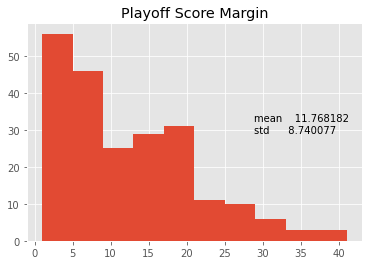

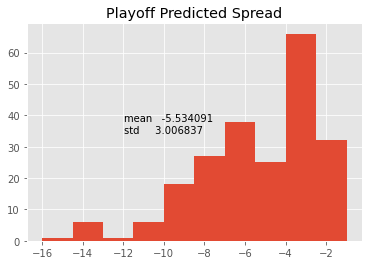

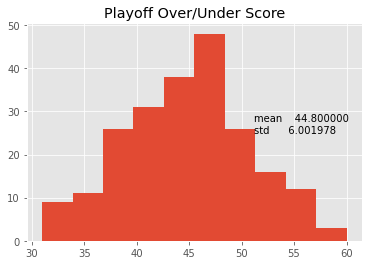

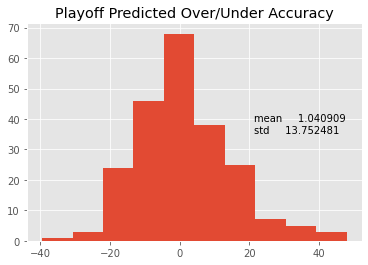

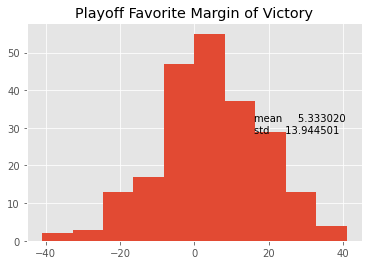

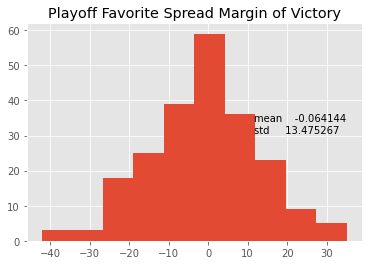

In [364]:
plt.hist(playoffs.score_difference)
plt.figtext(0.65,0.5, playoffs.score_difference.describe().loc[['mean','std']].to_string())
plt.title('Playoff Score Margin')
plt.show()
plt.hist(playoffs.spread_favorite)
plt.figtext(0.35,0.5, playoffs.spread_favorite.describe().loc[['mean','std']].to_string())
plt.title('Playoff Predicted Spread')
plt.show()
plt.hist(playoffs.over_under_line)
plt.figtext(0.65,0.5, playoffs.over_under_line.describe().loc[['mean','std']].to_string())
plt.title('Playoff Over/Under Score')
plt.show()
plt.hist(playoffs.over_under_accuracy)
plt.figtext(0.65,0.5, playoffs.over_under_accuracy.describe().loc[['mean','std']].to_string())
plt.title('Playoff Predicted Over/Under Accuracy')
plt.show()
plt.hist(playoffs.fav_MoV)
plt.figtext(0.65,0.5, df.fav_MoV.describe().loc[['mean','std']].to_string())
plt.title('Playoff Favorite Margin of Victory')
plt.show()
plt.hist(playoffs.fav_spread_MoV)
plt.figtext(0.65,0.5, df.fav_spread_MoV.describe().loc[['mean','std']].to_string())
plt.title('Playoff Favorite Spread Margin of Victory')
plt.show()

In [365]:
playoffs.describe().transpose()
#Summary statistic means and std's look incredibly similar to regular season, no significant differences other than less scoring

,count,mean,std,min,25%,50%,75%,max
schedule_season,220.0,2009.500000,5.779431,2000.0000,2004.750000,2009.500000,2014.250000,2019.000000
schedule_week,220.0,19.000000,0.955637,18.0000,18.000000,19.000000,20.000000,21.000000
schedule_playoff,220.0,1.000000,0.000000,1.0000,1.000000,1.000000,1.000000,1.000000
score_home,220.0,25.145455,10.636232,0.0000,17.000000,24.000000,31.000000,51.000000
score_away,220.0,20.695455,9.527800,0.0000,14.000000,20.000000,27.000000,48.000000
weather_temperature,220.0,56.265997,13.931600,-6.0000,50.463855,53.811688,72.000000,78.151316
weather_wind_mph,220.0,6.142345,4.307688,0.0000,0.000000,7.513072,8.739854,18.000000
stadium_open,220.0,1989.387218,19.459598,1926.0000,1975.000000,1998.500000,2002.000000,2017.000000
stadium_capacity,220.0,70253.552372,6502.286616,53250.0000,65515.000000,68949.500000,76125.000000,93605.000000
ELEVATION,220.0,188.241655,318.134830,0.9144,12.250000,142.036800,217.552400,1611.200000


In [366]:
home_win = "{:.2f}".format((sum((df.result == 1) & (df.stadium_neutral == 0)) / len(df)) * 100)
away_win = "{:.2f}".format((sum((df.result == 0) & (df.stadium_neutral == 0)) / len(df)) * 100)
under_line = "{:.2f}".format((sum((df.score_home + df.score_away) < df.over_under_line) / len(df)) * 100)
over_line = "{:.2f}".format((sum((df.score_home + df.score_away) > df.over_under_line) / len(df)) * 100)

#Summary Statistics to consider before gambling in the first place
print("Number of Games: " + str(len(df)))
print("Home Straight Up Win Percentage: " + home_win + "%")
print("Away Straight Up Win Percentage: " + away_win + "%")
print("Under Percentage: " + under_line + "%")
print("Over Percentage: " + over_line + "%")

Number of Games: 5324
Home Straight Up Win Percentage: 56.56%
Away Straight Up Win Percentage: 42.26%
Under Percentage: 49.81%
Over Percentage: 48.46%


## Machine Learning Section

### Classification Methods - predicting result of a game in whether the home team wins or not

In [367]:
df.columns

Index(['schedule_date', 'schedule_season', 'schedule_week', 'schedule_playoff',
       'division_game', 'team_home', 'home_nickname', 'score_home',
       'score_away', 'team_away', 'away_nickname', 'Winner', 'stadium_name',
       'stadium_neutral', 'weather_temperature', 'weather_wind_mph',
       'weather_detail', 'stadium_location', 'stadium_open', 'stadium_type',
       'stadium_weather_type', 'stadium_capacity', 'stadium_surface',
       'ELEVATION', 'team_favorite_id', 'spread_favorite', 'score_difference',
       'over_under_line', 'over_under_accuracy', 'fav_MoV', 'fav_spread_MoV',
       'home_favorite', 'away_favorite', 'result'],
      dtype='object')

In [368]:
from sklearn.model_selection import train_test_split, cross_val_score
y = df['result']
X = df[['schedule_season', 'schedule_week', 'schedule_playoff', 'division_game',
        'weather_temperature', 'weather_wind_mph', 'spread_favorite', 'score_difference',
       'over_under_line', 'over_under_accuracy', 'fav_spread_MoV', 'home_favorite', 'away_favorite']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=785)

In [369]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(min_samples_leaf=3)
tree.fit(X_train,y_train)
yhattree = tree.predict(X_test)
y_prob_tree = tree.predict_proba(X_test)[:,1]

print("Decision Tree Accuracy: ",accuracy_score(y_test, yhattree))
print("Decision Tree F1: ", f1_score(y_test, yhattree))
print("Decision Tree AUC: ", roc_auc_score(y_test, yhattree))

Decision Tree Accuracy:  0.9912390488110138
Decision Tree F1:  0.9923664122137406
Decision Tree AUC:  0.9912309368191721


In [370]:
#Random Forest
rf = RandomForestClassifier(n_jobs=-1)
parameters = {
    'n_estimators': [50, 250, 500],
    'max_depth': [5, 10, 50, 100, None]
}

cv = GridSearchCV(rf, parameters, cv=5)
cv.fit(X_train, y_train)

rf = RandomForestClassifier(max_depth=100, n_estimators=500, n_jobs=-1)
rf.fit(X_train, y_train)
yhatrf = (rf.predict(X_test))
y_prob_rf = rf.predict_proba(X_test)[:,1]

print("Random Forest Accuracy: ", accuracy_score(y_test, yhatrf))
print("Random Forest F1: ", f1_score(y_test, yhatrf))
print("Random Forest AUC: ", roc_auc_score(y_test, y_prob_rf))

Random Forest Accuracy:  0.9912390488110138
Random Forest F1:  0.9923747276688453
Random Forest AUC:  0.9996788094322697


In [371]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import RFE

#Using an Least Discriminate Analysis to try and narrow down my model
original = LDA()

# choose the best features for my model
rfe = RFE(original, 5)
rfe = rfe.fit(X, y)

# features
print(X.columns)
print(rfe.support_)
print(rfe.ranking_)


Index(['schedule_season', 'schedule_week', 'schedule_playoff', 'division_game',
       'weather_temperature', 'weather_wind_mph', 'spread_favorite',
       'score_difference', 'over_under_line', 'over_under_accuracy',
       'fav_spread_MoV', 'home_favorite', 'away_favorite'],
      dtype='object')
[False False False  True False False  True False False False  True  True
  True]
[6 4 3 1 7 9 1 2 5 8 1 1 1]


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [372]:
y = df['result']
new_X = df[['division_game', 'spread_favorite', 'fav_spread_MoV', 'home_favorite', 'away_favorite']]
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size = .3, random_state=785)

In [373]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(min_samples_leaf=3)
tree.fit(X_train,y_train)
yhattree = tree.predict(X_test)
y_prob_tree = tree.predict_proba(X_test)[:,1]

print("Decision Tree Accuracy: ",accuracy_score(y_test, yhattree))
print("Decision Tree F1: ", f1_score(y_test, yhattree))
print("Decision Tree AUC: ", roc_auc_score(y_test, yhattree))

Decision Tree Accuracy:  0.9949937421777222
Decision Tree F1:  0.9956379498364231
Decision Tree AUC:  0.9950708061002178


After narrowing down factors and ultimately settling upon those last 5, I concluded those were the best five in determining whether or not the result of the game would be the home team winning.

### Linear Regression/KNN Attempts - predicting score difference

I tried doing linear regression, except it didn't work well since so many variables were based off of each other. KNN regression model seemed to perform much better.

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


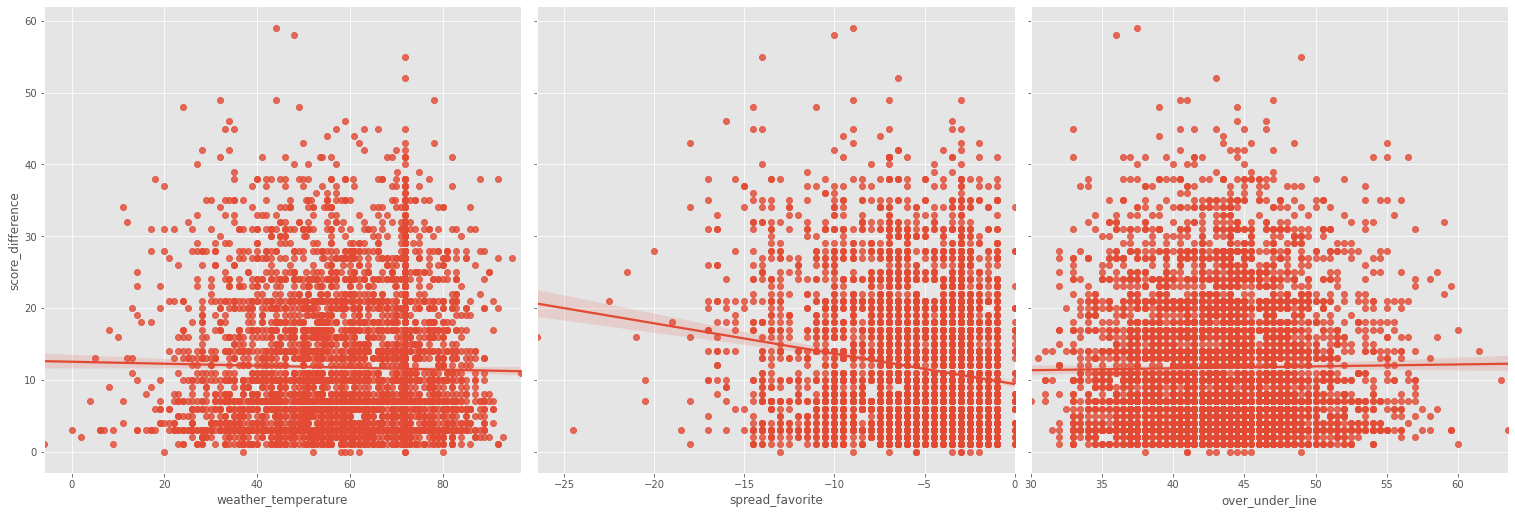

In [374]:
sns.pairplot(df, 
             x_vars=['weather_temperature', 'spread_favorite', 'over_under_line'], 
             y_vars='score_difference', size=7, kind='reg')

In [375]:
from sklearn.model_selection import train_test_split, cross_val_score
y = df['score_difference']
X = df[['spread_favorite', 'over_under_line', 'schedule_week', 'schedule_playoff', 'division_game', 'fav_spread_MoV']] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=785)

In [376]:
lm = LinearRegression()
lm.fit(X_train, y_train)
yhat_test = lm.predict(X_test)
mse_lm_tt = mean_squared_error(y_test, yhat_test)
print(mse_lm_tt)
print(r2_score(y_test, yhat_test))

68.50817231495157
0.24315533614559737


In [377]:
knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X_train, y_train)
yhat_knn_test = knn.predict(X_test)
mse_knn_tt = mean_squared_error(y_test, yhat_knn_test)
print(mse_knn_tt)
print(r2_score(y_test, yhat_knn_test))

1.5561118064246975
0.9828088405038893


In [378]:
lm = LinearRegression()
scores_lm = cross_val_score(lm, X, y, cv=10, scoring='neg_mean_squared_error')
mse_lm_cv = -1*scores_lm.mean()
print(mse_lm_cv)

66.59114763593605


In [379]:
knn = KNeighborsRegressor(n_neighbors=3)
scores_knn = cross_val_score(knn, X, y, cv=10, scoring='neg_mean_squared_error')
mse_knn_cv = -1*scores_knn.mean()
print(mse_knn_cv)

1.249993926341808


In [380]:
print('LinReg Train/Test: {0:.4f}'.format(mse_lm_tt))
print('KNN Train/Test: {0:.4f}'.format(mse_knn_tt))
print('LinReg 10-fold CV: {0:.4f}'.format(mse_lm_cv))
print('KNN 10-fold CV: {0:.4f}'.format(mse_knn_cv))


LinReg Train/Test: 68.5082
KNN Train/Test: 1.5561
LinReg 10-fold CV: 66.5911
KNN 10-fold CV: 1.2500


In [381]:
ols = LinearRegression()
model = ols.fit(X_train,y_train)


#Showing the MSE for this model
print("MSE (Training) : {:.3f}".format(mean_squared_error(y_train,ols.predict(X_train))))

#One way to check the fit (and evidence of overfitting) is to see 
#how it preforms in sample vs out of sample
print("OLS accuracy on training set: {:.3f}".format(ols.score(X_train, y_train)))



MSE (Training) : 65.403
OLS accuracy on training set: 0.223
